In [450]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm

In [451]:
# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU is not available.


## 1. Importing NYPD arrest data from catalog.data.gov

In [452]:
dats = pd.read_csv("NYPD_Arrest_Data.csv")

#### Looking at the number of entries (63,621), number of features (19), and summary statistics

In [453]:
dats.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,281240883,1/28/2024,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,Q,105,0,25-44,M,WHITE,1057545,207911,40.737043,-73.735514,POINT (-73.735514 40.737043)
1,282884120,2/27/2024,263.0,"ARSON 2,3,4",114.0,ARSON,PL 1501001,F,Q,107,71,45-64,M,WHITE,1037489,206343,40.732881,-73.807899,POINT (-73.807899 40.732881)
2,283137868,3/3/2024,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200502,F,B,48,0,25-44,M,BLACK,1013900,250835,40.855109,-73.892818,POINT (-73.892818 40.855109)
3,287001362,5/16/2024,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200512,F,S,121,0,25-44,M,WHITE,938928,168468,40.628967,-74.163275,POINT (-74.163275 40.628967)
4,287829614,6/2/2024,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,Q,100,0,25-44,M,BLACK,1039777,155013,40.591980,-73.800066,POINT (-73.800066 40.59198)


In [454]:
dats.describe()

,ARREST_KEY,PD_CD,KY_CD,ARREST_PRECINCT,JURISDICTION_CODE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
count,1.954470e+05,195441.000000,195421.000000,195447.000000,195447.000000,1.954470e+05,195447.000000,195447.000000,195447.000000
mean,2.870581e+08,430.651910,252.006115,63.563959,0.920991,1.005677e+06,207829.553199,40.736659,-73.921863
std,4.114243e+06,272.001338,145.826553,34.948675,6.988188,2.145326e+04,29518.704169,0.153439,0.248536
min,2.797635e+08,2.000000,101.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,-74.252711
25%,2.835069e+08,117.000000,113.000000,40.000000,0.000000,9.907960e+05,185773.000000,40.676499,-73.976436
50%,2.871294e+08,397.000000,340.000000,63.000000,0.000000,1.005312e+06,206901.000000,40.734496,-73.924029
75%,2.906267e+08,705.000000,344.000000,101.000000,0.000000,1.017933e+06,235604.000000,40.813333,-73.878333
max,2.941500e+08,997.000000,995.000000,123.000000,97.000000,1.067185e+06,271282.000000,40.911236,0.000000


In [455]:
dats.count()

ARREST_KEY                  195447
ARREST_DATE                 195447
PD_CD                       195441
PD_DESC                     195447
KY_CD                       195421
OFNS_DESC                   195447
LAW_CODE                    195447
LAW_CAT_CD                  194338
ARREST_BORO                 195447
ARREST_PRECINCT             195447
JURISDICTION_CODE           195447
AGE_GROUP                   195447
PERP_SEX                    195447
PERP_RACE                   195447
X_COORD_CD                  195447
Y_COORD_CD                  195447
Latitude                    195447
Longitude                   195447
New Georeferenced Column    195447
dtype: int64

#### The "New Georeferenced Column" is redundant, and adds no new information. The very same location information is already present in the "Latitude" and "Longitude" features. Therefore, we will drop it.

In [456]:
dats = dats.drop("New Georeferenced Column", axis = 1)

#### Additionally, the "ARREST_KEY" is a randomly generated persistent ID (primary key) for each arrest, and is therefore not related with any of the other features. Therefore, it will be removed.

In [457]:
dats = dats.drop("ARREST_KEY", axis = 1)

## 2. Handling missing values

In [458]:
dats.isnull().sum()

ARREST_DATE             0
PD_CD                   6
PD_DESC                 0
KY_CD                  26
OFNS_DESC               0
LAW_CODE                0
LAW_CAT_CD           1109
ARREST_BORO             0
ARREST_PRECINCT         0
JURISDICTION_CODE       0
AGE_GROUP               0
PERP_SEX                0
PERP_RACE               0
X_COORD_CD              0
Y_COORD_CD              0
Latitude                0
Longitude               0
dtype: int64

#### Because we have such a large dataset (63k entries), we will drop the roughly 400 entries with missing values.

In [459]:
dats = dats.dropna()

In [460]:
dats.isnull().sum()

ARREST_DATE          0
PD_CD                0
PD_DESC              0
KY_CD                0
OFNS_DESC            0
LAW_CODE             0
LAW_CAT_CD           0
ARREST_BORO          0
ARREST_PRECINCT      0
JURISDICTION_CODE    0
AGE_GROUP            0
PERP_SEX             0
PERP_RACE            0
X_COORD_CD           0
Y_COORD_CD           0
Latitude             0
Longitude            0
dtype: int64

## 3. Checking for mismatched string formats in the 8 categorical variables

In [461]:
pd_desc = dats["PD_DESC"].value_counts()
print(pd_desc)

PD_DESC
ASSAULT 3                         21266
LARCENY,PETIT FROM OPEN AREAS,    19904
ASSAULT 2,1,UNCLASSIFIED          11902
TRAFFIC,UNCLASSIFIED MISDEMEAN     9740
ROBBERY,OPEN AREA UNCLASSIFIED     9110
                                  ...  
FAIL TO STOP ON SIGNAL                1
PRIVACY,OFFENSES AGAINST,UNCLA        1
ARSON 1                               1
PEDESTRIAN / UNCLASSIDIED             1
SOLICITATION 3,2,1, CRIMINAL          1
Name: count, Length: 243, dtype: int64


In [462]:
dats["OFNS_DESC"].value_counts()

OFNS_DESC
ASSAULT 3 & RELATED OFFENSES        28892
PETIT LARCENY                       19904
FELONY ASSAULT                      17219
DANGEROUS DRUGS                     13731
MISCELLANEOUS PENAL LAW             12433
VEHICLE AND TRAFFIC LAWS            10149
ROBBERY                              9156
GRAND LARCENY                        9099
CRIMINAL MISCHIEF & RELATED OF       8955
OTHER OFFENSES RELATED TO THEFT      8641
DANGEROUS WEAPONS                    8287
OFFENSES AGAINST PUBLIC ADMINI       6705
BURGLARY                             4777
SEX CRIMES                           4612
FORGERY                              3739
OFFENSES INVOLVING FRAUD             3599
OFF. AGNST PUB ORD SENSBLTY &        3284
POSSESSION OF STOLEN PROPERTY        3097
OTHER STATE LAWS                     2761
CRIMINAL TRESPASS                    2034
INTOXICATED & IMPAIRED DRIVING       1971
OTHER TRAFFIC INFRACTION             1781
GRAND LARCENY OF MOTOR VEHICLE       1642
OFFENSES AGAINST THE PER

In [463]:
dats["LAW_CODE"].value_counts()

LAW_CODE
PL 1200001    20812
PL 1552500    19904
PL 1651503     8118
VTL0511001     6483
PL 215510B     6386
              ...  
VTL0511A3A        1
PL 2252001        1
PL 130661C        1
PL 1908302        1
PL 2404501        1
Name: count, Length: 1036, dtype: int64

In [464]:
dats["LAW_CAT_CD"].value_counts()

LAW_CAT_CD
M    109326
F     82522
V      1762
9       535
I       167
Name: count, dtype: int64

In [465]:
dats["ARREST_BORO"].value_counts()

ARREST_BORO
K    53810
M    45689
B    43663
Q    42834
S     8316
Name: count, dtype: int64

In [466]:
dats["AGE_GROUP"].value_counts()

AGE_GROUP
25-44    112844
45-64     37791
18-24     32979
<18        7243
65+        3455
Name: count, dtype: int64

In [467]:
dats["PERP_SEX"].value_counts()

PERP_SEX
M    159357
F     34955
Name: count, dtype: int64

In [468]:
dats["PERP_RACE"].value_counts()

PERP_RACE
BLACK                             90677
WHITE HISPANIC                    51967
BLACK HISPANIC                    19833
WHITE                             19510
ASIAN / PACIFIC ISLANDER          10956
UNKNOWN                             762
AMERICAN INDIAN/ALASKAN NATIVE      607
Name: count, dtype: int64

#### There do not appear to be any mismatched strings. However, this is difficult to tell for the PD_DESC and LAW_CODE columns because they have so many unique values.

## 4. Checking for outliers in the 8 numeric variables

#### The goal here is to catch the extreme outliers. Therefore, we will only be looking at values that are greater or lower than 5 standard deviations away from the mean.

In [469]:
def detect_outliers(df, column_name, threshold = 5):
    mean = df[column_name].mean()
    std = df[column_name].std()
    
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std

    values = []
    indices = []
    for ind, val in df[column_name].items():
        if val <= lower_bound or val >= upper_bound:
            values.append(val)
            indices.append(ind)
    if values != []:
        print(values)
    return indices

In [470]:
detect_outliers(dats, "PD_CD")

[]

In [471]:
detect_outliers(dats, "KY_CD")

[]

In [472]:
detect_outliers(dats, "ARREST_PRECINCT")

[]

In [473]:
detect_outliers(dats, "JURISDICTION_CODE")

[71, 51, 52, 72, 73, 87, 97, 51, 51, 97, 72, 97, 71, 97, 72, 97, 97, 73, 87, 87, 87, 72, 72, 73, 72, 72, 97, 73, 51, 72, 97, 71, 71, 72, 97, 97, 97, 71, 73, 97, 73, 72, 72, 72, 87, 72, 97, 72, 97, 52, 73, 87, 73, 73, 72, 87, 97, 72, 73, 72, 72, 73, 71, 97, 73, 72, 97, 71, 71, 87, 72, 72, 73, 97, 97, 97, 69, 72, 72, 72, 97, 72, 97, 79, 97, 97, 52, 71, 72, 72, 72, 72, 73, 71, 52, 72, 72, 97, 72, 97, 97, 87, 87, 51, 87, 72, 73, 51, 72, 72, 51, 71, 73, 51, 73, 72, 87, 72, 72, 51, 72, 97, 71, 72, 72, 97, 72, 73, 51, 97, 97, 73, 72, 72, 72, 97, 97, 97, 51, 97, 72, 87, 72, 97, 97, 73, 97, 51, 51, 97, 87, 71, 72, 73, 73, 73, 73, 72, 97, 87, 69, 72, 97, 72, 97, 73, 87, 73, 97, 72, 97, 72, 73, 85, 72, 72, 97, 97, 51, 97, 87, 51, 87, 87, 73, 97, 87, 72, 97, 72, 97, 97, 72, 97, 97, 72, 74, 72, 72, 97, 87, 73, 72, 72, 73, 87, 72, 72, 97, 97, 72, 72, 73, 97, 97, 97, 72, 51, 73, 72, 72, 51, 97, 97, 87, 51, 73, 71, 72, 72, 71, 71, 97, 87, 73, 72, 97, 87, 87, 72, 73, 51, 71, 51, 97, 72, 87, 52, 72, 97,

[1,
 35,
 86,
 199,
 275,
 341,
 999,
 1051,
 1122,
 1261,
 1704,
 1935,
 2037,
 2156,
 2331,
 2344,
 2352,
 2398,
 2492,
 2585,
 2685,
 2805,
 3100,
 3157,
 3296,
 3774,
 3829,
 4572,
 4619,
 4635,
 4719,
 4844,
 4861,
 5001,
 5218,
 5346,
 5425,
 5851,
 5977,
 6256,
 6445,
 6561,
 6685,
 6696,
 6716,
 7141,
 7151,
 7256,
 7258,
 7456,
 7606,
 7633,
 7672,
 7768,
 7800,
 7830,
 7960,
 8118,
 8160,
 8187,
 8243,
 8297,
 8336,
 8583,
 8707,
 8718,
 8976,
 8985,
 9343,
 9569,
 9769,
 9869,
 10067,
 10086,
 10128,
 10167,
 10202,
 10444,
 10478,
 10500,
 10960,
 10980,
 11165,
 11402,
 11599,
 11694,
 11706,
 12349,
 12510,
 12596,
 12636,
 12915,
 13020,
 13039,
 13313,
 13319,
 13323,
 13547,
 13642,
 13859,
 14253,
 14288,
 14334,
 14508,
 14593,
 14604,
 14687,
 14779,
 14828,
 14872,
 14897,
 15255,
 15274,
 15276,
 15308,
 15436,
 15506,
 15583,
 15674,
 16008,
 16228,
 16575,
 16595,
 16645,
 16654,
 16801,
 16835,
 16843,
 17074,
 17390,
 17603,
 17672,
 17690,
 17753,
 17814,
 18

In [474]:
detect_outliers(dats, "X_COORD_CD")

[0, 0]


[38222, 46032]

In [475]:
detect_outliers(dats, "Y_COORD_CD")

[0, 0]


[38222, 46032]

In [476]:
detect_outliers(dats, "Latitude")

[0.0, 0.0]


[38222, 46032]

In [477]:
outlier_ind = detect_outliers(dats, "Longitude")

[0.0, 0.0]


####  Unfortunately, the JURISDICTION_CODE feature ranges wildly. It really contains categorical data, as each jurisdiction is assigned a number. Therefore, we will not include it in this outlier detection analysis. However, we do notice that two rows are outliers when looking at the X_COORD, Y_COORD, Latitude, and Longitude features. It appears someone has inputted these features with values of 0 in these rows. We will now remove these rows from the dataset.

In [478]:
dats = dats.drop(outlier_ind)

In [479]:
dats_copy = dats.copy(deep=True)

## 5. Convert features with string datatype to categorical

In [480]:
dats['LAW_CAT_CD'] = pd.factorize(dats['LAW_CAT_CD'])[0]
dats['ARREST_BORO'] = pd.factorize(dats['ARREST_BORO'])[0]
dats['AGE_GROUP'] = pd.factorize(dats['AGE_GROUP'])[0]
dats['PERP_SEX'] = pd.factorize(dats['PERP_SEX'])[0]
dats['PERP_RACE'] = pd.factorize(dats['PERP_RACE'])[0]
dats['PD_DESC'] = pd.factorize(dats['PD_DESC'])[0]
dats['OFNS_DESC'] = pd.factorize(dats['OFNS_DESC'])[0]
dats['LAW_CODE'] = pd.factorize(dats['LAW_CODE'])[0]

#### Transforming the ARREST_DATE feature into month and day features. We won't include the year as everything is in 2024.

In [481]:
dats["ARREST_DATE_MONTH"] = pd.DatetimeIndex(dats["ARREST_DATE"]).month
dats["ARREST_DATE_DAY"] = pd.DatetimeIndex(dats["ARREST_DATE"]).day
dats = dats.drop("ARREST_DATE", axis = 1)

In [482]:
dats.describe()

,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,ARREST_DATE_MONTH,ARREST_DATE_DAY
count,194310.000000,194310.000000,194310.000000,194310.000000,194310.000000,194310.000000,194310.00000,194310.000000,194310.000000,194310.000000,194310.000000,194310.000000,1.943100e+05,194310.000000,194310.000000,194310.000000,194310.000000,194310.000000
mean,432.830559,28.704169,247.764603,12.854341,72.120241,0.592461,2.12339,63.683748,0.917163,0.716870,0.179888,1.624085,1.005733e+06,207812.495502,40.737023,-73.922452,5.047203,15.519026
std,271.193151,24.505115,134.974724,8.558258,96.756991,0.535184,1.56016,34.889910,6.958548,0.989663,0.384095,1.184136,2.120980e+04,29539.597134,0.081083,0.076494,2.571391,8.701252
min,100.000000,0.000000,101.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,9.139790e+05,121508.000000,40.499940,-74.252711,1.000000,1.000000
25%,117.000000,10.000000,113.000000,6.000000,13.000000,0.000000,1.00000,40.000000,0.000000,0.000000,0.000000,1.000000,9.907960e+05,185680.500000,40.676305,-73.976436,3.000000,8.000000
50%,397.000000,22.000000,250.000000,12.000000,45.000000,1.000000,3.00000,63.000000,0.000000,0.000000,0.000000,1.000000,1.005345e+06,206924.000000,40.734637,-73.923872,5.000000,15.000000
75%,705.000000,41.000000,344.000000,20.000000,90.000000,1.000000,4.00000,102.000000,0.000000,1.000000,0.000000,2.000000,1.017933e+06,235604.000000,40.813343,-73.878333,7.000000,23.000000
max,997.000000,242.000000,882.000000,56.000000,1035.000000,4.000000,4.00000,123.000000,97.000000,4.000000,1.000000,6.000000,1.067185e+06,271282.000000,40.911236,-73.700717,9.000000,31.000000


## 6. Data Visualization

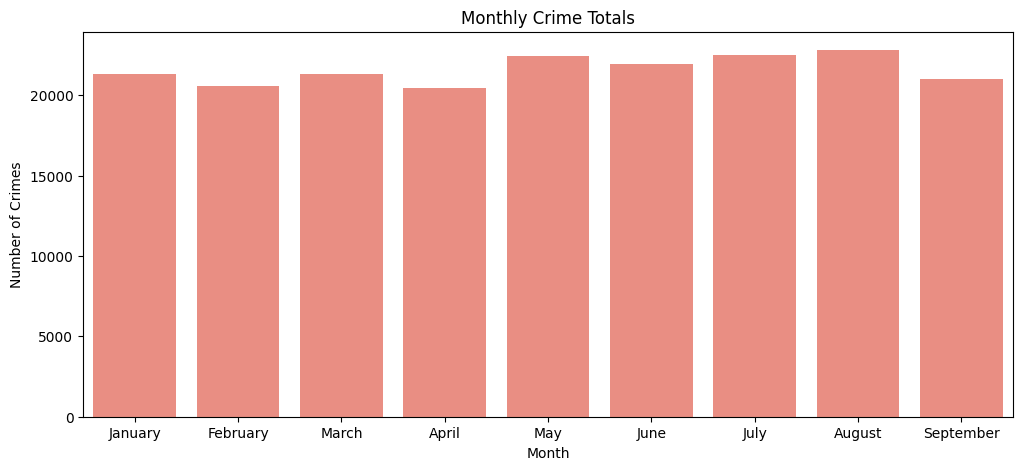

In [483]:
plt.subplots(figsize=(12,5))

ax = sns.countplot(dats, x='ARREST_DATE_MONTH', color='salmon')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September'])
ax.set_xlabel("Month")
ax.set_ylabel("Number of Crimes")

#ax.set_facecolor("lightgray")
#plt.gcf().set_facecolor("lightgray")

plt.title('Monthly Crime Totals')
plt.show()

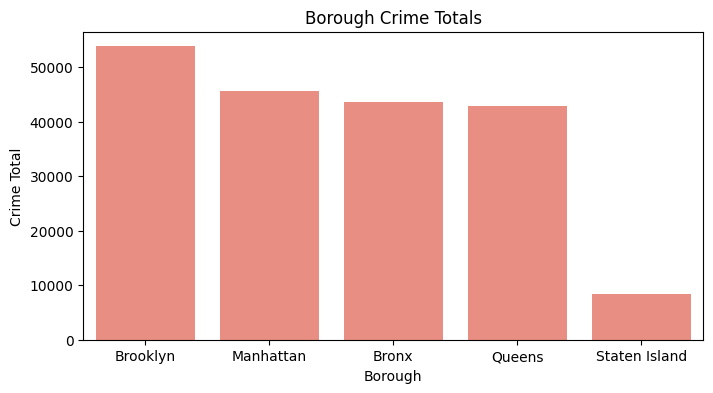

In [484]:
borough_map = {4: "Brooklyn", 3: "Manhattan", 1: "Bronx", 0: "Queens", 2: "Staten Island"}
dats_copy['ARREST_BORO'] = dats['ARREST_BORO'].map(borough_map)

plt.subplots(figsize=(8,4))

ax = sns.countplot(dats_copy, x='ARREST_BORO', order = dats_copy['ARREST_BORO'].value_counts().index, color='salmon')
ax.set_xlabel("Borough")
ax.set_ylabel("Crime Total")

plt.title('Borough Crime Totals')
plt.show()

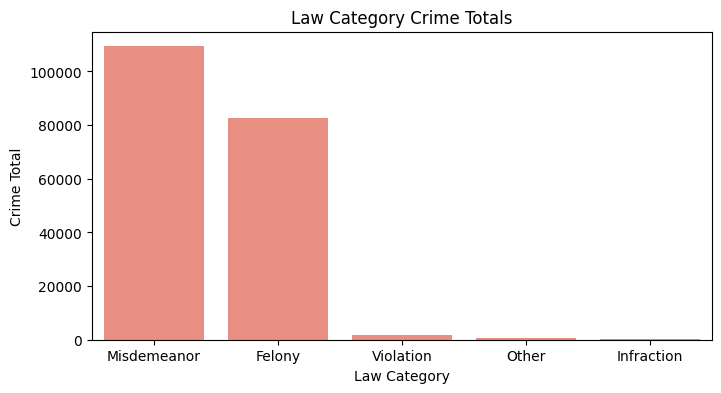

In [485]:
plt.subplots(figsize=(8,4))

ax = sns.countplot(dats_copy, x='LAW_CAT_CD', order = dats_copy['LAW_CAT_CD'].value_counts().index, color='salmon')

law_map = {'M': "Misdemeanor", 'F': "Felony", 'V': "Violation", '9': "Other", 'I': "Infraction"}
original_labels = [tick.get_text() for tick in ax.get_xticklabels()]
new_labels = [law_map[label] for label in original_labels]

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(new_labels)
ax.set_xlabel("Law Category")
ax.set_ylabel("Crime Total")

plt.title('Law Category Crime Totals')
plt.show()

<Axes: xlabel='Law Categories'>

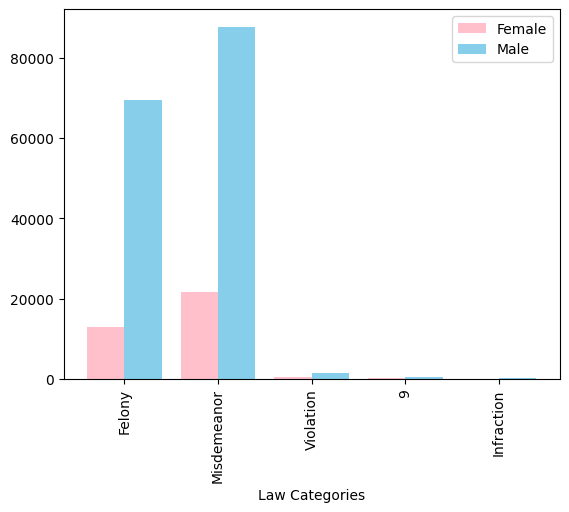

In [486]:
crime_counts_sex = original.groupby(['LAW_CAT_CD', 'PERP_SEX']).size().unstack()
categorized_crime_sex = pd.DataFrame({
    "Law Categories": ["Felony", "Misdemeanor", "Violation", "9", "Infraction"],
    "Female": [
        crime_counts_sex.loc['F', 'F'] if 'F' in crime_counts_sex.index else 0,
        crime_counts_sex.loc['M', 'F'] if 'M' in crime_counts_sex.index else 0,
        crime_counts_sex.loc['V', 'F'] if 'V' in crime_counts_sex.index else 0,
        crime_counts_sex.loc['9', 'F'] if '9' in crime_counts_sex.index else 0,
        crime_counts_sex.loc['I', 'F'] if 'I' in crime_counts_sex.index else 0
    ],
    "Male": [
        crime_counts_sex.loc['F', 'M'] if 'F' in crime_counts_sex.index else 0,
        crime_counts_sex.loc['M', 'M'] if 'M' in crime_counts_sex.index else 0,
        crime_counts_sex.loc['V', 'M'] if 'V' in crime_counts_sex.index else 0,
        crime_counts_sex.loc['9', 'M'] if '9' in crime_counts_sex.index else 0,
        crime_counts_sex.loc['I', 'M'] if 'I' in crime_counts_sex.index else 0
    ]
})
categorized_crime_sex.plot.bar(x='Law Categories', y=['Female', 'Male'], color=['pink', 'skyblue'], width=0.8)

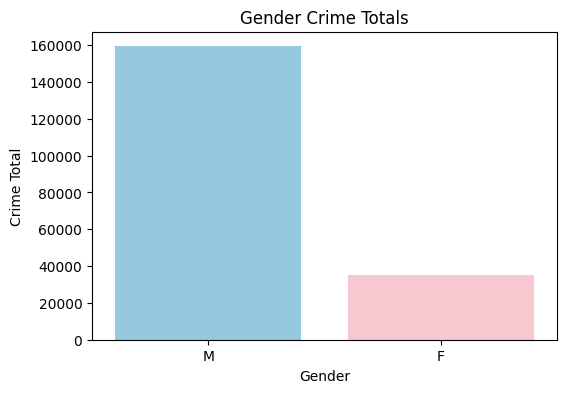

In [487]:
plt.subplots(figsize=(6,4))

ax = sns.countplot(dats_copy, x='PERP_SEX', order=dats_copy['PERP_SEX'].value_counts().index, hue='PERP_SEX', palette=['skyblue', 'pink'])
ax.set_xlabel("Gender")
ax.set_ylabel("Crime Total")

plt.title('Gender Crime Totals')
plt.show()

## 7. Correlation

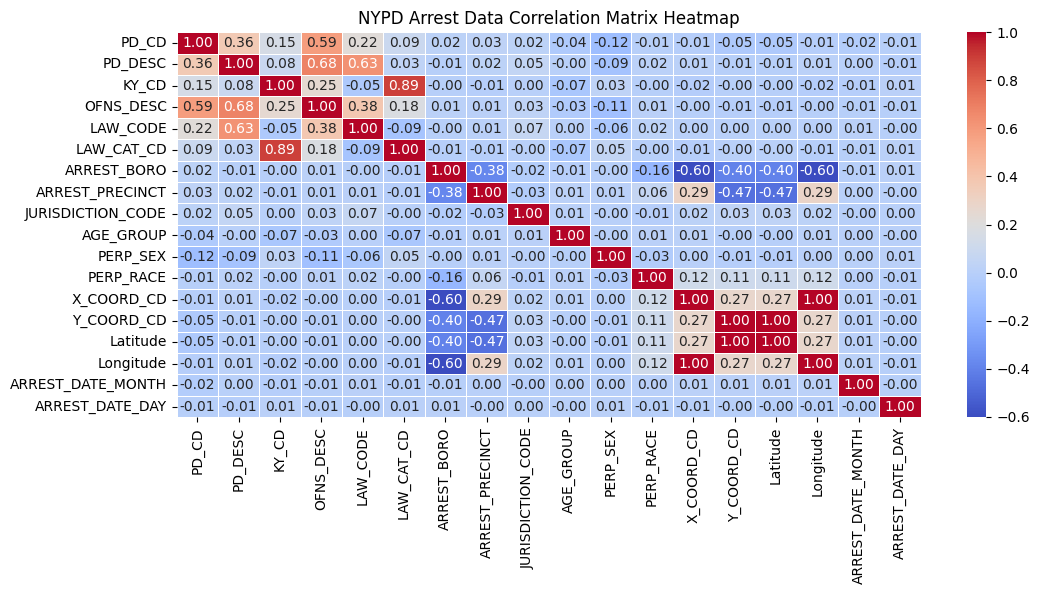

In [488]:
correl = dats.corr()
plt.figure(figsize=(12,5))
sns.heatmap(correl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('NYPD Arrest Data Correlation Matrix Heatmap')
plt.show()

## 8. Choosing target variable and features

#### We are going to predict the perpetrator's sex using "PD_CD", "PD_DESC", and "OFNS_DESC" because these variables have the highest correlation among the available features.

In [489]:
target = ["PERP_SEX"]
features = ["PD_CD", "PD_DESC", "OFNS_DESC"]

In [490]:
new_dats = dats[features]
new_dats = new_dats.join(dats[target])

In [491]:
new_dats.head()

,PD_CD,PD_DESC,OFNS_DESC,PERP_SEX
0,105.0,0,0,0
1,263.0,1,1,0
2,109.0,2,0,0
3,109.0,2,0,0
4,105.0,0,0,0


## 9. Normalize non-categorical variables

In [492]:
scaler = StandardScaler()
col_to_scale = ["PD_CD"]
new_dats[col_to_scale] = scaler.fit_transform(new_dats[col_to_scale])

In [493]:
new_dats.head()

,PD_CD,PD_DESC,OFNS_DESC,PERP_SEX
0,-1.208848,0,0,0
1,-0.626236,1,1,0
2,-1.194099,2,0,0
3,-1.194099,2,0,0
4,-1.208848,0,0,0


## 10. Train, Validation, and Test Split (70/15/15) for DataLoader

In [494]:
train, temp = train_test_split(new_dats, test_size = 0.3, random_state = 5)
test, val = train_test_split(temp, test_size = 0.5, random_state = 5)

In [495]:
x_train = torch.tensor(train.drop(columns = ["PERP_SEX"]).values, dtype=torch.float32)
y_train = torch.tensor(train["PERP_SEX"].values, dtype=torch.long)
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
num_features = len(x_train[0])

In [496]:
x_val = torch.tensor(val.drop(columns = ["PERP_SEX"]).values, dtype=torch.float32)
y_val = torch.tensor(val["PERP_SEX"].values, dtype=torch.long)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=32, shuffle=True)

In [497]:
x_test = torch.tensor(test.drop(columns = ["PERP_SEX"]).values, dtype=torch.float32)
y_test = torch.tensor(test["PERP_SEX"].values, dtype=torch.long)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=32, shuffle=True)

In [498]:
print("Training Data: features followed by target")
for features, target in train_loader:
    print(features.shape)
    print(target.shape)
    break

Training Data: features followed by target
torch.Size([32, 3])
torch.Size([32])


# Neural Network

In [499]:
class NeuralNet(nn.Module):
    # Input Layer (5 features of NYPD arrest data)
    
    def __init__(self, in_features = num_features, out_features = 2):
        super().__init__() #instantiates our nn.Model
        self.fc1 = nn.Linear(in_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.out = nn.Linear(16, out_features)
    
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.out(x)
        
        return x

# Create an instance of the model
model = NeuralNet()
print(model)

NeuralNet(
  (fc1): Linear(in_features=3, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=2, bias=True)
)


# Training Function with Validation Early Stopping

In [500]:
def train_model(model, train_dataloader, val_dataloader, num_epochs, optimizer, loss_function, val_patience=3):
    train_loss, val_loss = [], [] # initializing loss lists
    train_acc, val_acc = [], []  # initializing accuracy lists
    previous_val_loss = float('inf')
    val_patience = val_patience
    val_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_running_loss, train_running_correct = 0.0, 0

        progress_bar_train = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch")
        for data in progress_bar_train:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad() # zeroing the parameters

            outputs = model(inputs) # forward pass through the model

            loss = loss_function(outputs, targets) # calculating the loss
            train_running_loss += loss.item() * inputs.size(0)
            # multiplying the loss by the number of samples in the batch, thereby weighting its loss value
            # this is because the last batch may have fewer samples

            loss.backward() # backpropogation
            optimizer.step()

           # determining accurate predictions
            _, preds = torch.max(outputs, 1)
            train_running_correct += torch.sum(preds == targets.data)

        # calculating/appending epoch loss and accuracy
        epoch_loss = train_running_loss / len(train_dataloader.dataset) # dividing by the total number of samples
        epoch_acc = train_running_correct.double() / len(train_dataloader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc.item())

        model.eval()
        val_running_loss, val_running_correct = 0.0, 0

        with torch.no_grad():
            progress_bar_val = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch")
            for val_data in progress_bar_val:
                inputs, targets = val_data
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs) # forward pass
                loss = loss_function(outputs, targets) # loss calculation
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_correct += torch.sum(preds == targets.data) # determining accurate predictions

        # calculating/appending epoch loss and accuracy
        val_epoch_loss = val_running_loss / len(val_dataloader.dataset)
        val_epoch_acc = val_running_correct.double() / len(val_dataloader.dataset)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc.item())

        print(f'Epoch {epoch+1:2d} | Train Loss: {epoch_loss:.4f}, Train Acc: {(epoch_acc)*100:.2f} | Val Loss: {val_epoch_loss:.4f}, Val Acc: {(val_epoch_acc)*100:.2f}')

        # Early stopping
        if val_loss[-1] > previous_val_loss:
            val_counter += 1
            if val_counter >= val_patience:
                print('Early stopping condition met. Validation loss is increasing.')
                break
        else:
            previous_val_loss = val_loss[-1]
            val_counter = 0

    return train_loss, train_acc, val_loss, val_acc

In [501]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, model_type):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title(f'{model_type} - Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.title(f'{model_type} - Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Test Function

In [502]:
def evaluate_model(model, test_dataloader, loss_function):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        with tqdm(test_dataloader, desc='Testing', unit='batch') as test_data:
            for inputs, targets in test_data:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = loss_function(outputs, targets)
                running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == targets.data)

                all_predictions.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

    test_loss = running_loss / len(test_dataloader.dataset)
    test_acc = running_corrects.double() / len(test_dataloader.dataset)

    print('\n')
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")
    print('\n')

    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Test Set Confusion Matrix')
    plt.show()

    # report_metrics = classification_report(all_targets, all_predictions)
    # print('\n')
    # print(report_metrics)

    return test_loss, test_acc

Epoch 1/500 - Validation: 100%|██████████| 911/911 [00:00<00:00, 1058.63batch/s]


Epoch  1 | Train Loss: 0.4594, Train Acc: 82.06 | Val Loss: 0.4562, Val Acc: 82.10


Epoch 2/500 - Validation: 100%|██████████| 911/911 [00:00<00:00, 993.89batch/s] 


Epoch  2 | Train Loss: 0.4543, Train Acc: 82.07 | Val Loss: 0.4529, Val Acc: 82.10


Epoch 3/500 - Validation: 100%|██████████| 911/911 [00:01<00:00, 695.71batch/s]


Epoch  3 | Train Loss: 0.4525, Train Acc: 82.07 | Val Loss: 0.4502, Val Acc: 82.10


Epoch 4/500 - Validation: 100%|██████████| 911/911 [00:01<00:00, 815.46batch/s]


Epoch  4 | Train Loss: 0.4511, Train Acc: 82.07 | Val Loss: 0.4487, Val Acc: 82.10


Epoch 5/500 - Validation: 100%|██████████| 911/911 [00:01<00:00, 902.50batch/s] 


Epoch  5 | Train Loss: 0.4493, Train Acc: 82.07 | Val Loss: 0.4456, Val Acc: 82.10


Epoch 6/500 - Validation: 100%|██████████| 911/911 [00:01<00:00, 789.72batch/s]


Epoch  6 | Train Loss: 0.4478, Train Acc: 82.07 | Val Loss: 0.4455, Val Acc: 82.10


Epoch 7/500 - Validation: 100%|██████████| 911/911 [00:01<00:00, 760.98batch/s]


Epoch  7 | Train Loss: 0.4472, Train Acc: 82.07 | Val Loss: 0.4462, Val Acc: 82.10


Epoch 8/500 - Validation: 100%|██████████| 911/911 [00:00<00:00, 963.18batch/s] 


Epoch  8 | Train Loss: 0.4465, Train Acc: 82.07 | Val Loss: 0.4446, Val Acc: 82.10


Epoch 9/500 - Validation: 100%|██████████| 911/911 [00:01<00:00, 589.01batch/s]


Epoch  9 | Train Loss: 0.4460, Train Acc: 82.07 | Val Loss: 0.4438, Val Acc: 82.10


Epoch 10/500 - Validation: 100%|██████████| 911/911 [00:01<00:00, 810.68batch/s]


Epoch 10 | Train Loss: 0.4457, Train Acc: 82.07 | Val Loss: 0.4438, Val Acc: 82.10


Epoch 11/500 - Validation: 100%|██████████| 911/911 [00:01<00:00, 757.98batch/s]


Epoch 11 | Train Loss: 0.4457, Train Acc: 82.07 | Val Loss: 0.4439, Val Acc: 82.10


Epoch 12/500 - Validation: 100%|██████████| 911/911 [00:01<00:00, 901.44batch/s] 


Epoch 12 | Train Loss: 0.4452, Train Acc: 82.07 | Val Loss: 0.4432, Val Acc: 82.10


Epoch 13/500 - Validation: 100%|██████████| 911/911 [00:00<00:00, 952.18batch/s] 


Epoch 13 | Train Loss: 0.4453, Train Acc: 82.07 | Val Loss: 0.4436, Val Acc: 82.09


Epoch 14/500 - Validation: 100%|██████████| 911/911 [00:00<00:00, 1077.00batch/s]


Epoch 14 | Train Loss: 0.4450, Train Acc: 82.06 | Val Loss: 0.4458, Val Acc: 81.76


Epoch 15/500 - Validation: 100%|██████████| 911/911 [00:00<00:00, 1016.87batch/s]


Epoch 15 | Train Loss: 0.4449, Train Acc: 82.07 | Val Loss: 0.4428, Val Acc: 82.10


Epoch 16/500 - Validation: 100%|██████████| 911/911 [00:00<00:00, 1022.69batch/s]


Epoch 16 | Train Loss: 0.4447, Train Acc: 82.07 | Val Loss: 0.4453, Val Acc: 82.10


Epoch 17/500 - Validation: 100%|██████████| 911/911 [00:00<00:00, 1018.45batch/s]


Epoch 17 | Train Loss: 0.4448, Train Acc: 82.07 | Val Loss: 0.4444, Val Acc: 82.09


Epoch 18/500 - Validation: 100%|██████████| 911/911 [00:00<00:00, 1033.15batch/s]


Epoch 18 | Train Loss: 0.4449, Train Acc: 82.07 | Val Loss: 0.4435, Val Acc: 82.10
Early stopping condition met. Validation loss is increasing.


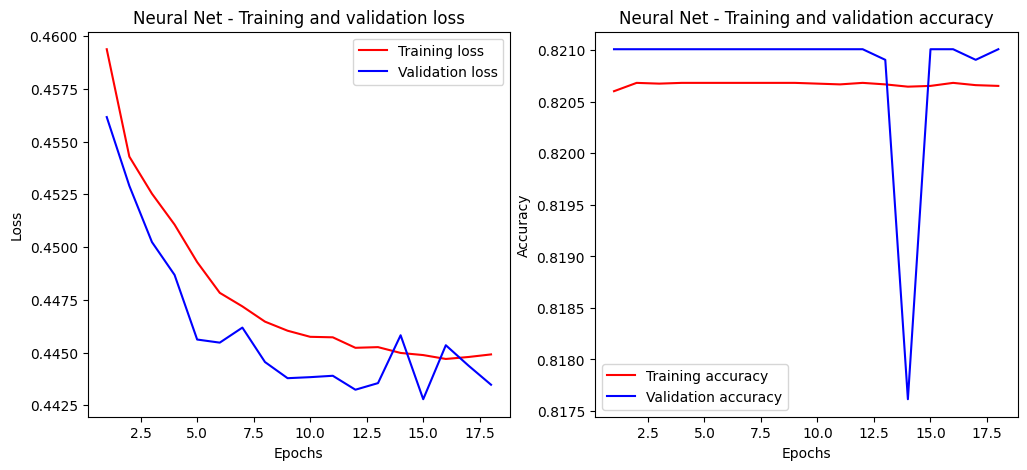

In [503]:
model = NeuralNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
num_epochs = 500

train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, num_epochs, optimizer, criterion)
plot_metrics(train_loss, train_acc, val_loss, val_acc, 'Neural Net')

Testing: 100%|██████████| 911/911 [00:01<00:00, 842.48batch/s]




Test Loss: 0.4540, Test Accuracy: 81.65%




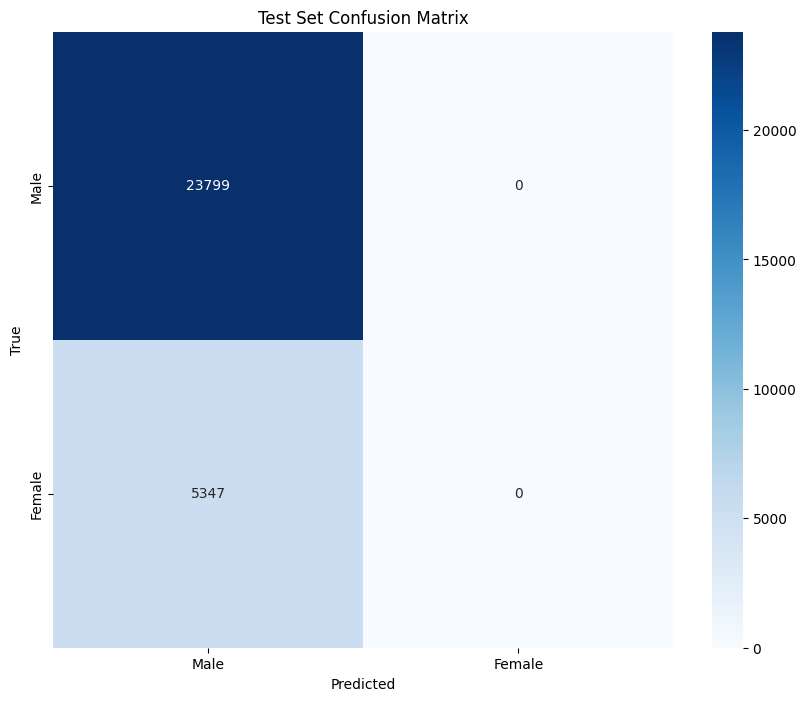

In [504]:
classes = ["Male", "Female"]
nn_test_loss, nn_test_acc = evaluate_model(model, test_loader, criterion)